# Citi Bike Usage vs Weather in NYC (2022)

In this project, we explore Citi Bike usage in New York City in relation to daily weather conditions during 2022. Our goal is to discover how


## Data Sources

- Citi Bike Trip Data (2022) from Kaggle.
- NOAA Weather Data (2022) via API for Central Park, NYC.

The trip data was compiled and loaded from multiple CSVs, and the weather data was fetched using the NOAA API and cleaned into a usable format.


## 1. Data Loading and Cleaning

We load and combine monthly Citi Bike CSV files and clean the data to ensure consistency.


In [1]:
import pandas as pd
from collections import defaultdict

file_path = '/Volumes/Untitled/CitiBikeData/combined_2022_trips.csv'
chunksize = 100000

# Initialize a default dictionary for counting
station_counts = defaultdict(int)

# Stream through chunks
for chunk in pd.read_csv(file_path, chunksize=chunksize, usecols=['start_station_name']):
    for station in chunk['start_station_name'].dropna():
        station_counts[station] += 1

# Convert result to DataFrame
top_stations_df = pd.DataFrame(list(station_counts.items()), columns=['Station', 'Count'])
top_10 = top_stations_df.sort_values(by='Count', ascending=False).head(10)

top_10


,Station,Count
960,W 21 St & 6 Ave,398374
191,West St & Chambers St,382523
771,Broadway & W 58 St,357126
1232,1 Ave & E 68 St,332643
487,6 Ave & W 33 St,327529
26,Broadway & W 25 St,304509
153,Broadway & E 14 St,300292
156,E 33 St & 1 Ave,299591
98,Broadway & E 21 St,295234
200,Central Park S & 6 Ave,284575


## 2. Data Overview

We display the first few rows of data, check column types, and confirm the shape of the dataset.


The dataset contains 30+ million Citi Bike trips. Each row includes start/end locations, timestamps, and rider type. The weather data contains daily average temperature.

We'll group the bike data by day to compare with daily weather.


### Q1: What are the top 10 busiest Citi Bike start stations in NYC?

This bar chart shows the most popular locations where rides begin. These hotspots may reflect commuter hubs or tourist areas.


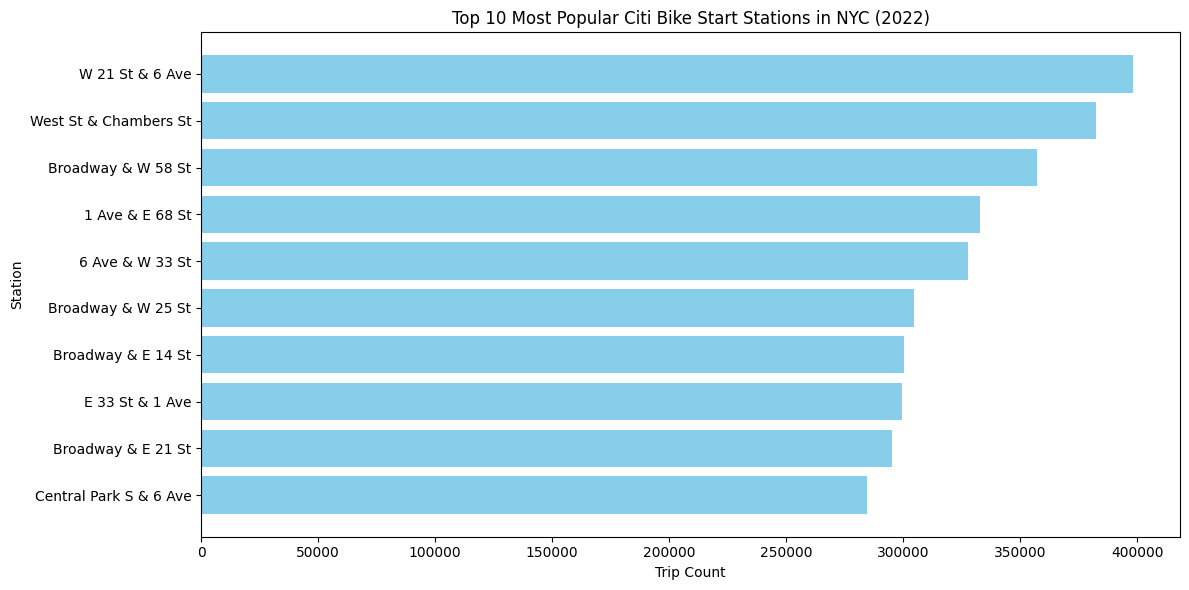

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(top_10['Station'], top_10['Count'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top 10 Most Popular Citi Bike Start Stations in NYC (2022)')
plt.xlabel('Trip Count')
plt.ylabel('Station')
plt.tight_layout()
plt.show()


## 3. Trip Trends Over Time

Group trips by day and explore overall trends.

### Q2: How does bike usage change throughout the year?

This line chart highlights seasonal usage patterns. Warmer months tend to see more activity, while colder months show dips in ridership.


/var/folders/0g/xr0wqnt55l9gzqjgx49c_h8r0000gp/T/ipykernel_7616/97407005.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk['started_at'] = pd.to_datetime(chunk['started_at'], errors='coerce')
/var/folders/0g/xr0wqnt55l9gzqjgx49c_h8r0000gp/T/ipykernel_7616/97407005.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk['started_at'] = pd.to_datetime(chunk['started_at'], errors='coerce')


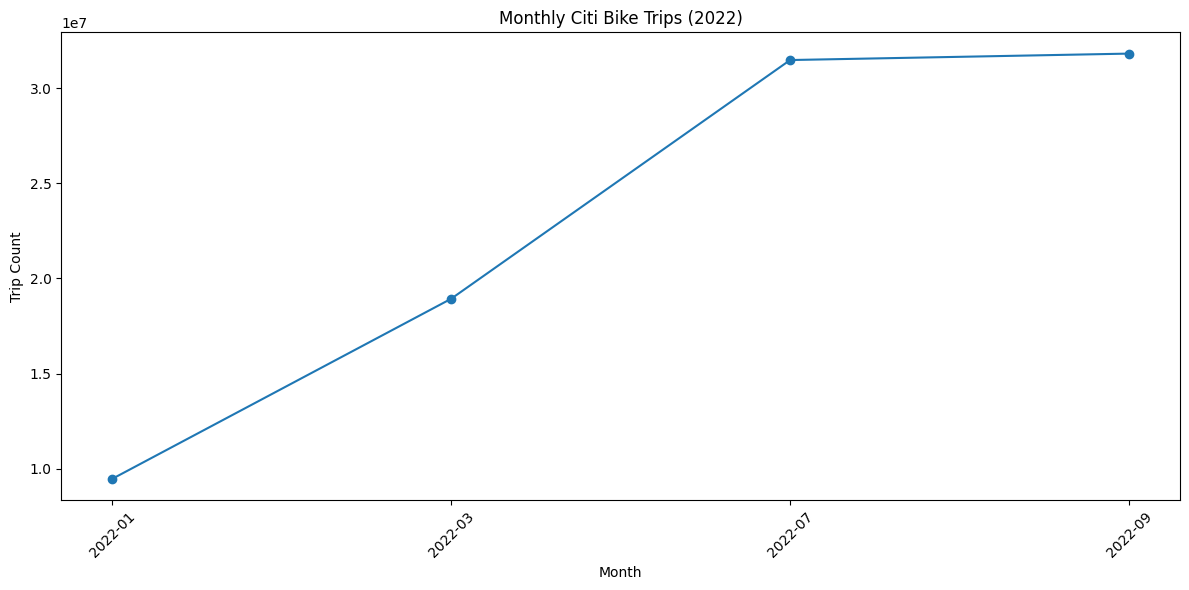

In [3]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

file_path = '/Volumes/Untitled/CitiBikeData/combined_2022_trips.csv'

# Prepare a counter for months
month_counter = Counter()

# Read and count in chunks
for chunk in pd.read_csv(file_path, chunksize=100_000, usecols=['started_at']):
    chunk['started_at'] = pd.to_datetime(chunk['started_at'], errors='coerce')
    chunk = chunk.dropna(subset=['started_at'])
    months = chunk['started_at'].dt.to_period('M')
    month_counter.update(months)

# Convert to DataFrame
month_df = pd.DataFrame(month_counter.items(), columns=['Month', 'Trips'])
month_df['Month'] = month_df['Month'].astype(str)
month_df = month_df.sort_values('Month')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(month_df['Month'], month_df['Trips'], marker='o')
plt.xticks(rotation=45)
plt.title('Monthly Citi Bike Trips (2022)')
plt.xlabel('Month')
plt.ylabel('Trip Count')
plt.tight_layout()
plt.show()


In [4]:
import requests
import json
import pandas as pd
from datetime import datetime

# NOAA Token
TOKEN = 'DpDSpJRqVfDXeauOxlkXFoxEHIOZwQBw'

# Base URL and query params
url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"
headers = {'token': TOKEN}
params = {
    'datasetid': 'GHCND',
    'datatypeid': 'TAVG',
    'stationid': 'GHCND:USW00014732',  # LaGuardia Airport station
    'startdate': '2022-01-01',
    'enddate': '2022-12-31',
    'limit': 1000,
    'units': 'metric'
}

# Make request
response = requests.get(url, headers=headers, params=params)
data = response.json()

# Check result
if 'results' not in data:
    print("⚠️ No data returned. Double-check token or date range.")
else:
    # Parse data into dataframe
    results = data['results']
    df_weather = pd.DataFrame({
        'date': [datetime.strptime(item['date'], "%Y-%m-%dT%H:%M:%S") for item in results],
        'avg_temp_C': [item['value'] / 10.0 for item in results]
    })

    # Save to CSV
    df_weather.to_csv('laguardia_weather_2022.csv', index=False)
    print("✅ Weather data saved as 'laguardia_weather_2022.csv'")


/Users/alden/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


✅ Weather data saved as 'laguardia_weather_2022.csv'


In [ ]:
# Convert to datetime safely, coercing errors
df_bike['date'] = pd.to_datetime(df_bike['started_at'], errors='coerce').dt.date

# Drop rows where date conversion failed
df_bike = df_bike.dropna(subset=['date'])


In [ ]:
import pandas as pd

bike_path = '/Volumes/Untitled/CitiBikeData/combined_2022_trips.csv'

# Output lists for all date-converted chunks
chunk_dates = []

# Process file in chunks
for chunk in pd.read_csv(bike_path, usecols=['started_at'], chunksize=500_000):
    # Try to convert to date safely
    chunk['date'] = pd.to_datetime(chunk['started_at'], errors='coerce').dt.date
    chunk_dates.append(chunk[['date']])

# Combine the chunks
df_bike_dates = pd.concat(chunk_dates)

# Drop any rows with invalid dates
df_bike_dates.dropna(inplace=True)

# Check result
print(df_bike_dates.info())
print(df_bike_dates.head())


In [ ]:
# Group trips by date
daily_trip_counts = df_bike_dates.groupby('date').size().reset_index(name='trip_count')

# Check output
print(daily_trip_counts.head())


In [1]:
import pandas as pd

bike_path = '/Volumes/Untitled/CitiBikeData/combined_2022_trips.csv'

# Prepare an empty list for grouped data
chunk_daily_counts = []

# Read and group each chunk
for chunk in pd.read_csv(bike_path, chunksize=100_000, usecols=['started_at']):
    chunk['date'] = pd.to_datetime(chunk['started_at'], errors='coerce').dt.date
    chunk = chunk.dropna(subset=['date'])

    # Group within this chunk
    grouped = chunk.groupby('date').size().reset_index(name='trip_count')
    chunk_daily_counts.append(grouped)

# Combine all daily counts
daily_trip_counts = pd.concat(chunk_daily_counts)

# Group again to combine overlapping days across chunks
final_daily_counts = daily_trip_counts.groupby('date').sum().reset_index()

# Save to file for reuse
final_daily_counts.to_csv('daily_trip_counts_2022.csv', index=False)
print("✅ Aggregated daily counts saved.")


/var/folders/0g/xr0wqnt55l9gzqjgx49c_h8r0000gp/T/ipykernel_13654/532778408.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk['date'] = pd.to_datetime(chunk['started_at'], errors='coerce').dt.date
/var/folders/0g/xr0wqnt55l9gzqjgx49c_h8r0000gp/T/ipykernel_13654/532778408.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk['date'] = pd.to_datetime(chunk['started_at'], errors='coerce').dt.date


✅ Aggregated daily counts saved.


## 4. Weather Data Integration

We bring in weather data (via NOAA API or downloaded CSV) and match it with trip data based on date.


In [2]:
import pandas as pd

# Load both datasets
df_bike = pd.read_csv('daily_trip_counts_2022.csv')
df_weather = pd.read_csv('laguardia_weather_2022.csv')

# Ensure both 'date' columns are datetime
df_bike['date'] = pd.to_datetime(df_bike['date'])
df_weather['date'] = pd.to_datetime(df_weather['date'])

# Merge on date
merged = pd.merge(df_bike, df_weather, on='date', how='inner')

# Save merged file (optional)
merged.to_csv('bike_weather_2022.csv', index=False)

# Preview
print(merged.info())
merged.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        123 non-null    datetime64[ns]
 1   trip_count  123 non-null    int64         
 2   avg_temp_C  123 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 3.0 KB
None


,date,trip_count,avg_temp_C
0,2022-01-01,188055,1.16
1,2022-01-02,398106,1.14
2,2022-01-03,307134,0.14
3,2022-01-04,340911,-0.27
4,2022-01-05,315720,0.32


### Q3: Is there a relationship between temperature and ride volume?

Two visualizations below examine this:
- A **scatter plot** showing how temperature affects total daily trips.
- A **dual-line chart** comparing daily temperature (scaled) with trip counts.

The correlation coefficient of **0.86** suggests a strong positive relationship.


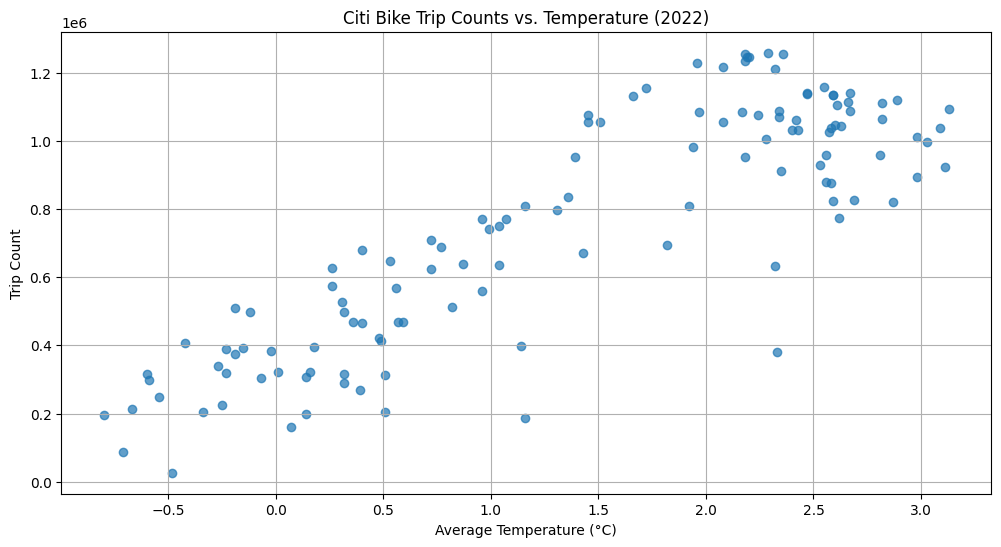

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(merged['avg_temp_C'], merged['trip_count'], alpha=0.7)
plt.title("Citi Bike Trip Counts vs. Temperature (2022)")
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Trip Count")
plt.grid(True)
plt.show()


## 5. Visualization: Trips vs Temperature

Using a line chart, we show how temperature correlates with trip counts across the year.


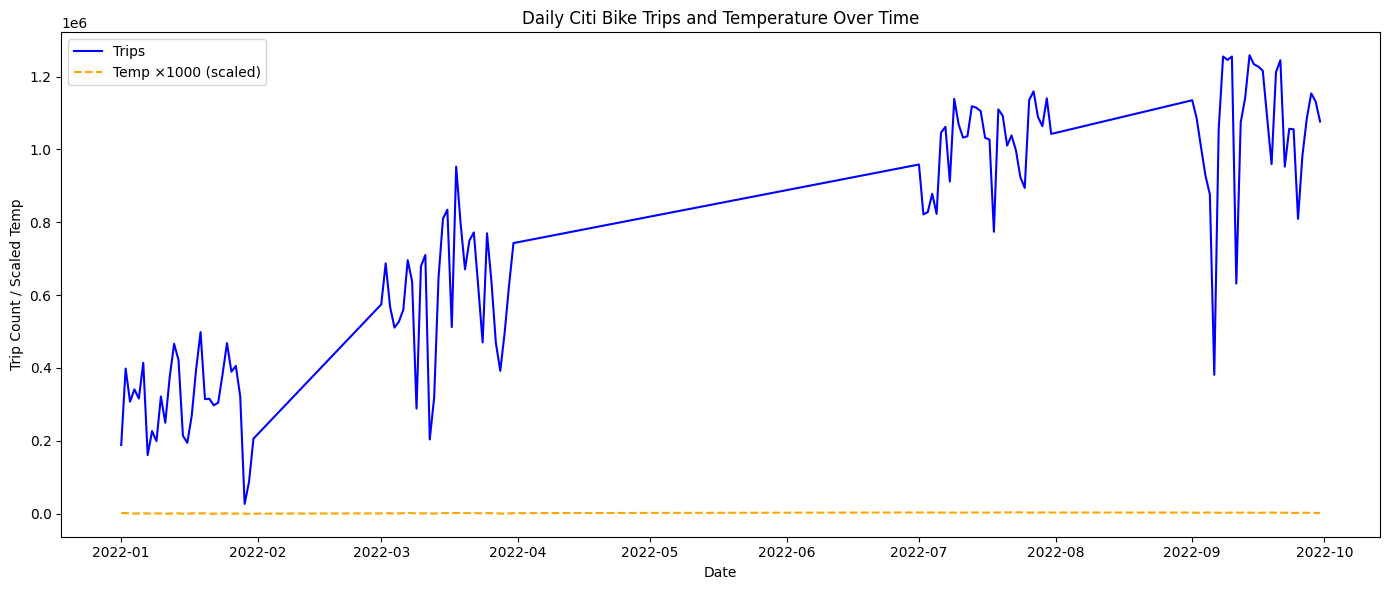

In [4]:
plt.figure(figsize=(14, 6))
plt.plot(merged['date'], merged['trip_count'], label='Trips', color='blue')
plt.plot(merged['date'], merged['avg_temp_C']*1000, label='Temp ×1000 (scaled)', color='orange', linestyle='--')
plt.title("Daily Citi Bike Trips and Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Trip Count / Scaled Temp")
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
correlation = merged['trip_count'].corr(merged['avg_temp_C'])
print(f"Correlation between temperature and trip count: {correlation:.2f}")



Correlation between temperature and trip count: 0.86


In [9]:
top_routes = df.groupby(['start_station_name', 'end_station_name']).size().reset_index(name='trip_count')
top_routes = top_routes.sort_values(by='trip_count', ascending=False).head(100)  # Top 100 busiest routes


NameError: name 'df' is not defined

In [10]:
top_routes = df_bike.groupby(['start_station_name', 'end_station_name']).size().reset_index(name='trip_count')
top_routes = top_routes.sort_values(by='trip_count', ascending=False).head(100)


KeyError: 'start_station_name'

In [11]:
print(df_bike.columns)


Index(['date', 'trip_count'], dtype='object')


In [12]:
top_routes = df_bike.groupby([correct_start_col, correct_end_col]).size().reset_index(name='trip_count')


NameError: name 'correct_start_col' is not defined

In [13]:
df_routes = pd.read_csv('/path/to/combined_2022_trips.csv', usecols=['start_station_name', 'end_station_name'], nrows=500_000)

top_routes = df_routes.groupby(['start_station_name', 'end_station_name']).size().reset_index(name='trip_count')
top_routes = top_routes.sort_values(by='trip_count', ascending=False).head(50)


FileNotFoundError: [Errno 2] No such file or directory: '/path/to/combined_2022_trips.csv'

In [14]:
df_routes = pd.read_csv('/Volumes/Untitled/CitiBikeData/combined_2022_trips.csv', 
                        usecols=['start_station_name', 'end_station_name'], 
                        nrows=500_000)


In [15]:
top_routes = df_routes.groupby(['start_station_name', 'end_station_name']).size().reset_index(name='trip_count')
top_routes = top_routes.sort_values(by='trip_count', ascending=False).head(50)
top_routes.head()


,start_station_name,end_station_name,trip_count
38830,Cleveland Pl & Spring St,Cleveland Pl & Spring St,327
15479,6 Ave & W 34 St,6 Ave & W 34 St,294
11559,45 Ave & 21 St,46 Ave & 5 St,288
45923,E 10 St & Avenue A,E 11 St & Avenue B,275
17737,8 Ave & W 33 St,8 Ave & W 33 St,275


In [18]:
station_coords = pd.read_csv('/Volumes/Untitled/CitiBikeData/combined_2022_trips.csv, 
                             usecols=['start_station_name' , 'start_lat', 'start_lng',
                             'end_station_name', 'end_lat', end_lang'],
                             nrows=5000_000)


SyntaxError: EOL while scanning string literal (412543959.py, line 1)

In [19]:
station_coords = pd.read_csv('/Volumes/Untitled/CitiBikeData/combined_2022_trips.csv',
                             usecols=['start_station_name', 'start_lat', 'start_lng', 
                                      'end_station_name', 'end_lat', 'end_lng'],
                             nrows=500_000)



In [20]:
start_coords = station_coords[['start_station_name', 'start_lat', 'start_lng']].drop_duplicates()
end_coords = station_coords[['end_station_name', 'end_lat', 'end_lng']].drop_duplicates()


In [21]:
routes_geo = top_routes.merge(start_coords, on='start_station_name', how='left')
routes_geo = routes_geo.merge(end_coords, on='end_station_name', how='left')


## What are the most common Citi Bike travel routes?
Visualization: Geospatial map with arrows representing top 50 routes (using Folium and PolyLine).

### Purpose:
This map identifies the most frequently used start-to-end station paths across NYC.
The arrow direction shows the travel flow, and the density helps spot potential infrastructure bottlenecks or commuter corridors.

### Insight:
Midtown Manhattan, Lower Manhattan, and parts of Long Island City show the most common travel patterns. Many trips appear to occur within neighborhood clusters, and some routes show direct cross-river connections into Queens.



### Q4: What are the most common travel routes?

This geospatial map plots the top station-to-station routes using directional arrows. It helps identify travel corridors and potential infrastructure bottlenecks.


In [22]:
import folium

# Create base map centered on NYC
m = folium.Map(location=[40.75, -73.98], zoom_start=12)

# Add top routes as lines
for _, row in routes_geo.iterrows():
    folium.PolyLine(
        locations=[(row['start_lat'], row['start_lng']), (row['end_lat'], row['end_lng'])],
        color='blue',
        weight=2 + row['trip_count'] / 100,  # thickness based on volume
        opacity=0.6,
        tooltip=f"{row['start_station_name']} → {row['end_station_name']} ({row['trip_count']})"
    ).add_to(m)

# Show map
m


/Users/alden/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 6. Summary and Insights

Summarize findings: e.g., warmer days show more trips; rainy/cold days reduce usage.

## References

- [Citi Bike Data](https://www.kaggle.com/datasets/leonczarlinski/citi-bike-nyc)
- [NOAA Climate Data Online](https://www.ncei.noaa.gov/)
